
GONG PFSS extrapolation
=======================

Calculating PFSS solution for a GONG synoptic magnetic field map.


First, import required modules



In [16]:
import astropy.constants as const
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sunpy.map

import pfsspy
from pfsspy import coords
from pfsspy import tracing
#from gong_helpers import get_gong_map


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Load a GONG magnetic field map. If 'gong.fits' is present in the current
directory, just use that, otherwise download a sample GONG map.



In [17]:
def get_gong_map():
    """
    Automatically download and unzip a sample GONG synoptic map.
    """
    if not os.path.exists('190310t0014gong.fits') and not os.path.exists('190310t0014gong.fits.gz'):
        import urllib.request
        urllib.request.urlretrieve(
            'https://gong2.nso.edu/oQR/zqs/201903/mrzqs190310/mrzqs190310t0014c2215_333.fits.gz',
            '190310t0014gong.fits.gz')

    if not os.path.exists('190310t0014gong.fits'):
        import gzip
        with gzip.open('190310t0014gong.fits.gz', 'rb') as f:
            with open('190310t0014gong.fits', 'wb') as g:
                g.write(f.read())

    return '190310t0014gong.fits'

gong_fname = get_gong_map()

We can now use SunPy to load the GONG fits file, and extract the magnetic
field data.

The mean is subtracted to enforce div(B) = 0 on the solar surface: n.b. it is
not obvious this is the correct way to do this, so use the following lines
at your own risk!



In [18]:
gong_map = sunpy.map.Map(gong_fname)
# Remove the mean
gong_map = sunpy.map.Map(gong_map.data - np.mean(gong_map.data), gong_map.meta)

The PFSS solution is calculated on a regular 3D grid in (phi, s, rho), where
rho = ln(r), and r is the standard spherical radial coordinate. We need to
define the number of rho grid points, and the source surface radius.



In [19]:
nrho = 35
rss = 2.5

From the boundary condition, number of radial grid points, and source
surface, we now construct an Input object that stores this information



In [20]:
input = pfsspy.Input(gong_map, nrho, rss)


def set_axes_lims(ax):
    ax.set_xlim(0, 360)
    ax.set_ylim(0, 180)

Using the Input object, plot the input field



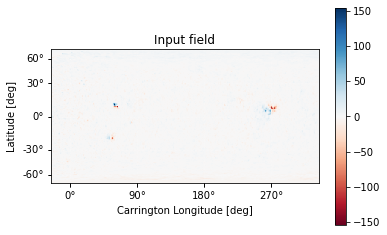

In [21]:
m = input.map
fig = plt.figure()
ax = plt.subplot(projection=m)
m.plot()
plt.colorbar()
ax.set_title('Input field')
set_axes_lims(ax)

Now calculate the PFSS solution, and plot the polarity inversion line.



In [22]:
output = pfsspy.pfss(input)
# output.plot_pil(ax)

Using the Output object we can plot the source surface field, and the
polarity inversion line.



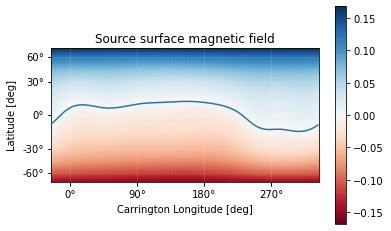

In [23]:
ss_br = output.source_surface_br
# Create the figure and axes
fig = plt.figure()
ax = plt.subplot(projection=ss_br)

# Plot the source surface map
ss_br.plot()
# Plot the polarity inversion line
ax.plot_coord(output.source_surface_pils[0])
# Plot formatting
plt.colorbar()
ax.set_title('Source surface magnetic field')
set_axes_lims(ax)

It is also easy to plot the magnetic field at an arbitrary height within
the PFSS solution.



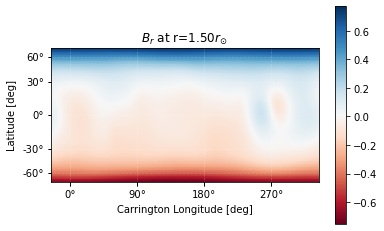

In [24]:
# Get the radial magnetic field at a given height
ridx = 15
br = output.bc[0][:, :, ridx]
# Create a sunpy Map object using output WCS
br = sunpy.map.Map(br.T, output.source_surface_br.wcs)
# Get the radial coordinate
r = np.exp(output.grid.rc[ridx])

# Create the figure and axes
fig = plt.figure()
ax = plt.subplot(projection=br)

# Plot the source surface map
br.plot(cmap='RdBu')
# Plot formatting
plt.colorbar()
ax.set_title('$B_{r}$ ' + f'at r={r:.2f}' + '$r_{\\odot}$')
set_axes_lims(ax)

Finally, using the 3D magnetic field solution we can trace some field lines.
In this case 64 points equally gridded in theta and phi are chosen and
traced from the source surface outwards.



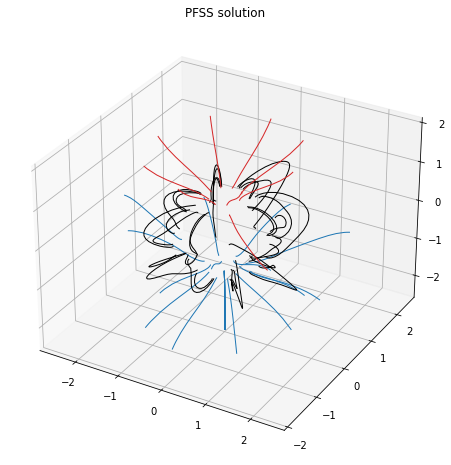

In [25]:

%matplotlib inline

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d' )

tracer = tracing.PythonTracer()
r = 1.2 * const.R_sun
lat = np.linspace(-np.pi / 2, np.pi / 2, 8, endpoint=False)
lon = np.linspace(0, 2 * np.pi, 8, endpoint=False)
lat, lon = np.meshgrid(lat, lon, indexing='ij')
lat, lon = lat.ravel() * u.rad, lon.ravel() * u.rad

seeds = SkyCoord(lon, lat, r, frame=output.coordinate_frame)

field_lines = tracer.trace(seeds, output)

for field_line in field_lines:
    color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(field_line.polarity)
    coords = field_line.coords
    coords.representation_type = 'cartesian'
    ax.plot(coords.x / const.R_sun,
            coords.y / const.R_sun,
            coords.z / const.R_sun,
            color=color, linewidth=1)

ax.set_title('PFSS solution')
plt.show()

# sphinx_gallery_thumbnail_number = 4